In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sstats.sigp as sigp

In [33]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=7, cores=7,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=4)
#
client = Client(cluster)

In [34]:
def correlate_np(u, v,
              biased=True,
              one_sided=True,
              weights=False,
#              mode = 'full'
             ):
    """ custom correlation
      corr[lag] = 1/w(lag) sum_lag u(t) x v(t+lag)
    Parameters
    ----------
    u, v: np.array
        Input timeseries, must be of the same length
    biased: boolean, optional
        Returns a biased estimation of the correlation. Default is True
            Biased: corr[lag] = 1/N sum ...
            Unbiased: corr[lag] = 1/(N-lag) sum ...
    one_sided: boolean, optional
        Outputs only positive lag. Default is True
    weights: boolean, optional
        Returns weights. Default is False
    Returns
    -------
    c: np.array
        Autocorrelation
    lag: np.array of int
        Lag in index (nondimensional units)
    w: np.array of int
        Weights used for the calculation of the autocorrelation
    """
    n = u.size
    assert u.size==v.size, "input vectors must have the same size"
    # build arrays of weights
    if biased:
        w = n #// 2
    else:
        _w = np.arange(1,n+1)
        w = np.hstack([_w, _w[-2::-1]])
    #
    c = np.correlate(u[:], v, mode="full") / w #n//2
#    lag = np.arange(0,n//2+1)#
    lag = np.arange(-n+1,n)
    #
    if one_sided:
        c, lag = c[n-1:], lag[n-1:]
        if not biased:
            w = w[n-1:]
    if weights:
        return c, lag, w
    else:
        return c, lag

def _correlate(v1, v2, dt=None, detrend=False, ufunc=True, **kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time
    and along the same time line.
    Note: takes the complex conjugate of v2
    Parameters
    ----------
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
        dt: float, optional
            Time step
        detrend: boolean, optional
            Turns detrending on or off. Default is False.
    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''

#    assert v1.shape == v2.shape

    #_correlate = np.correlate
    #_correlate = correlate_np

    if detrend:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)

    #_kwargs = {'mode': 'same'}
    #_kwargs.update(**kwargs)

    # loop over all dimensions but the last one to apply correlate
    if len(v1.shape)==1:
        vv, lags = correlate_np(v1, v2, **kwargs)
    else:
        Ni = v1.shape[:-1]
        # infer number of lags from dummy computation
        i0 = tuple(0 for i in Ni) + np.s_[:,]
        f, lags = correlate_np(v1[i0], v2[i0], **kwargs)
        vv = np.full(Ni+f.shape, np.NaN, dtype=v1.dtype)
        for ii in np.ndindex(Ni):
            f, _lags = correlate_np(v1[ii + np.s_[:,]],
                                    v2[ii + np.s_[:,]],
                                    **kwargs,
                                    )
            Nj = f.shape
            for jj in np.ndindex(Nj):
                vv[ii + jj] = f[jj]

    # select only positive lags
    #vv = vv[..., int(vv.shape[-1]/2):]

    # normalized by number of points
    #vv = vv/v1.shape[-1]
    # normalization done in correlate_np

    if ufunc:
        return vv
    else:
        #lags = np.arange(vv.shape[-1])*dt
        if len(vv.shape)==3:
            vv = vv.transpose((2,1,0))
        elif len(vv.shape)==2:
            vv = vv.transpose((1,0))
        return lags*dt, vv

def correlate(v1, v2,
              lags=None,
              #maxlag=None,
              **kwargs,
              ):
    """ Lagged cross-correlation with xarray objects
    Parameters:
    -----------
    v1, v2: xr.DataArray
        Input arrays, need to have a dimension called 'time'
    !working? ! lags: np.array
        Array of lags in input array time units
    !not working ! maxlag: float, optional
        Maximum lag in input arrays, index units
    **kwargs:
        Passed to np.correlate
    """

    # make sure time is last
    dims_ordered = [d for d in v1.dims if d!="time"]+ ["time"]
    v1 = v1.transpose(*dims_ordered)
    v2 = v2.transpose(*dims_ordered)
    # rechunk along time
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})

    _kwargs = dict(**kwargs)
    _kwargs["dt"] = float( (v1.time[1]-v1.time[0]).values )

    #if maxlag is not None:
    #    _kwargs["maxlag"] = int(maxlag/_kwargs["dt"])
    #print(_kwargs["maxlag"])

    if lags is None:
        _v1 = v1.isel(**{d: slice(0,2) for d in v1.dims if d!='time'})
        _v2 = v2.isel(**{d: slice(0,2) for d in v2.dims if d!='time'})
        lags, _ = _correlate(_v1, _v2, ufunc=False, **_kwargs)
        return correlate(v1, v2, lags=lags, **_kwargs)

    gufunc_kwargs = dict(output_sizes={'lags': lags.size})
    C = xr.apply_ufunc(_correlate, v1, v2,
                dask='parallelized', output_dtypes=[v1.dtype],
                input_core_dims=[['time'], ['time']],
                output_core_dims=[['lags']],
                dask_gufunc_kwargs=gufunc_kwargs,
                kwargs=_kwargs,
                )
    return C.assign_coords(lags=lags).rename(v1.name+'_'+v2.name)


In [35]:
root_dir = '/home1/datawork/zcaspar/mit4320/'
#'/Users/zcaspar/codes/mit4320/'
#ds_low = xr.open_dataset(root_dir+'ds_synthetic_lf.nc').compute()
#/Users/zcaspar/codes/mit4320/ds_lf.nc

In [18]:
dt = 1/24
lags = np.arange(0,ds_low.time.size,dt)
ds_autocov = correlate(ds_low.u_bar,ds_low.u_bar,biased=True,one_sided=False)#.persist()

In [19]:
ds = ds_autocov.compute()

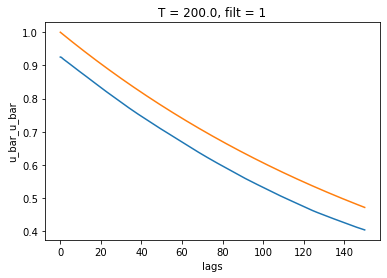

In [20]:
ds.isel(filt=1,T=-1).mean('draw').plot()
plt.plot(ds.lags.values,np.exp(-ds.lags.values/200))
#ds.isel(filt=1,T=1).mean('draw').plot()

In [21]:
ds.to_netcdf('/home1/datawork/zcaspar/mit4320/lf_autocov.nc')

In [36]:
ds_hf = xr.open_zarr(root_dir+'ds_synthetic_total.zarr').persist()
E_hf = xr.open_dataset(root_dir+'E_total.nc')#.persist()

In [38]:
E_bis = (abs(ds_hf.MS_demodulated)**2).mean('time').compute()

In [40]:
E_hf

<xarray.Dataset>
Dimensions:         (T: 4, rms: 4, T_low: 3, draw: 500, bandwidth: 3, signal: 3)
Coordinates:
  * T               (T) float64 5.0 10.0 20.0 40.0
  * rms             (rms) float64 0.01 0.1 1.0 2.0
  * T_low           (T_low) float64 2.0 20.0 200.0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    filt            int64 ...
  * bandwidth       (bandwidth) float64 0.2 0.4 0.6
  * signal          (signal) object 'coherent' 'mixed' 'incoherent'
Data variables:
    M2_demodulated  (bandwidth, signal, rms, T_low, draw, T) float64 ...
    MS_demodulated  (bandwidth, signal, rms, T_low, draw, T) float64 ...

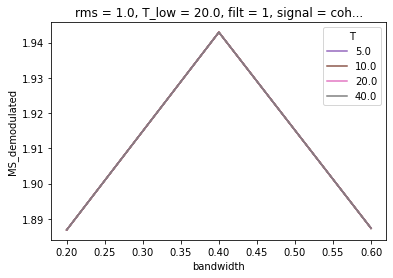

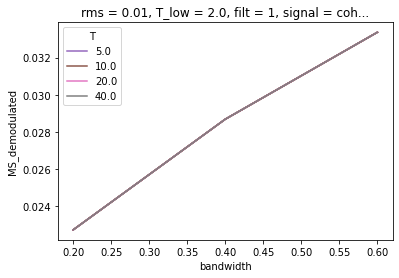

In [42]:
E_bis.sel(rms=1,signal='coherent',T_low=20).mean('draw').plot(hue='T')

E_hf.MS_demodulated.sel(rms=1,signal='coherent',T_low=20).mean('draw').plot(hue='T')

plt.figure()
E_bis.sel(rms=0.01,signal='coherent',T_low=2).mean('draw').plot(hue='T')
E_hf.MS_demodulated.sel(rms=0.01,signal='coherent',T_low=2).mean('draw').plot(hue='T')

In [15]:
v1 =ds_hf['M2_demodulated_real'].sel(draw=1,T=10,rms=1,bandwidth=0.4,signal='mixed').compute()
v2 = ds_hf['M2_demodulated_real'].sel(draw=1,T=10,rms= 1,bandwidth=0.4,signal='mixed').compute()

KeyError: 'M2_demodulated_real'

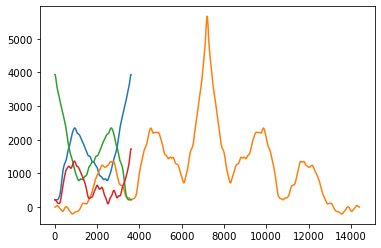

In [25]:
plt.plot(np.correlate(v1,v2[v1.size//2:],mode='valid'))
plt.plot(np.correlate(v1,v2,mode='full'))
plt.plot(np.correlate(v1[v1.size//2:],v2,mode='valid'))
plt.plot(np.correlate(v1[:v1.size//2],v2,mode='valid'))

In [16]:
for  c in ['M2','MS']:
    ds_hf[c+'_demodulated_real'] = ds_hf[c+'_demodulated'].real
    ds_hf[c+'_demodulated_imag'] = ds_hf[c+'_demodulated'].imag

In [8]:
dt = 1/24
s = "incoherent"
#lags = np.arange(0,ds_low.time.size,dt)
v1,v2 = ds_hf['M2_demodulated_real'].sel(bandwidth=0.4,rms=1,T=20),ds_hf['MS_demodulated_real'].sel(bandwidth=0.4,rms=1,T=20)
ds_autocov_hf = correlate(v1,v2,biased=False,one_sided=True).persist()

In [9]:
ds_autocov_hf = ds_autocov_hf.compute()

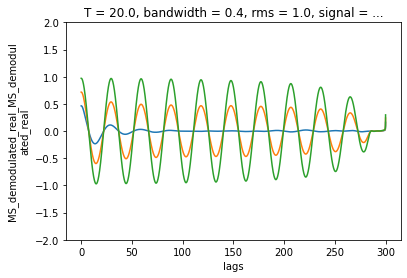

In [10]:
ds_autocov_hf.sel(signal='incoherent').mean('draw').plot(ylim=(-2,2))
ds_autocov_hf.sel(signal='mixed').mean('draw').plot(ylim=(-2,2))
ds_autocov_hf.sel(signal='coherent').mean('draw').plot(ylim=(-2,2))
#ds_autocov_hf.mean('draw').plot()
#ds_autocov_hf.mean('draw').plot()

In [14]:
dt = 1/24
#lags = np.arange(0,ds_low.time.size,dt)
v1,v2 = ds_hf['M2_demodulated_real'],ds_hf['M2_demodulated_real']
ds_autocov_hf = correlate(v1,v2,biased=False,one_sided=True).persist()

In [15]:
ds_autocov_hf = ds_autocov_hf.compute()

In [8]:
test = ds_autocov_hf.mean('draw').compute()

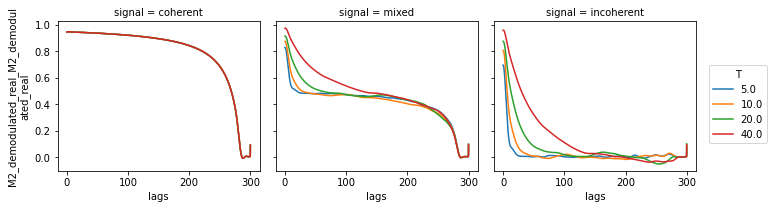

In [9]:
test.sel(rms=1,bandwidth=0.2).plot(hue='T',col='signal')

In [16]:
v1,v2 = ds_hf['M2_demodulated_real'],ds_hf['M2_demodulated_imag']
ds_cov_hf = correlate(v1,v2,biased=False,one_sided=True).persist()

In [17]:
ds_cov_hf = ds_cov_hf.compute()

In [17]:
v1,v2 = ds_hf['MS_demodulated_real'],ds_hf['MS_demodulated_real']
ds_autocov_hf_MS = correlate(v1,v2,biased=False,one_sided=True).persist()

In [18]:
ds_autocov_hf_MS = ds_autocov_hf_MS.compute()

In [19]:
_mean = ds_autocov_hf_MS.mean('draw')

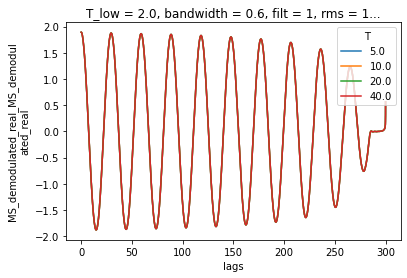

In [23]:
_mean.sel(T_low=2,signal='coherent',rms=1,bandwidth=0.6).plot(hue='T')

In [25]:
ds_hf['MS_demodulated'] = ds_hf['MS_demodulated_real']+1j*ds_hf['MS_demodulated_imag']

In [27]:
E_total = (abs(ds_hf['MS_demodulated'])**2).mean('time').compute()

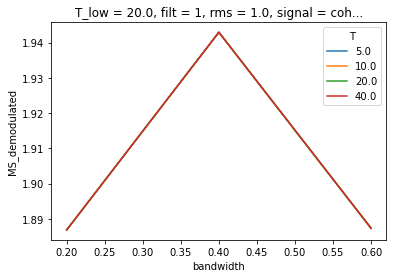

In [30]:
E_total.sel(rms=1,signal='coherent',T_low=20).mean('draw').plot(hue='T')

In [9]:
v1,v2 = ds_hf['MS_demodulated_real'],ds_hf['MS_demodulated_imag']
ds_cov_hf_MS = correlate(v1,v2,biased=False,one_sided=True).persist()

In [10]:
ds_cov_hf_MS = ds_cov_hf_MS.compute()

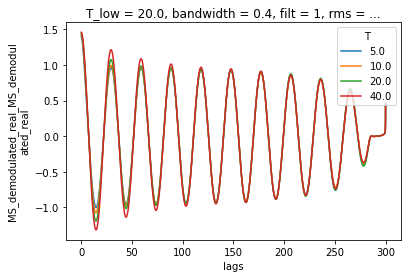

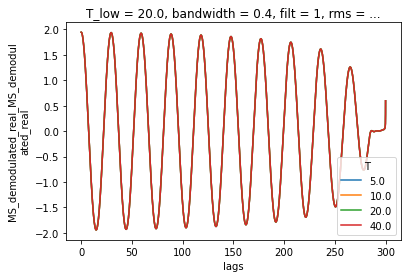

In [11]:
ds_autocov_hf_MS.sel(rms=1,signal='mixed',bandwidth=0.4,T_low=20
                     ).mean('draw').plot(hue='T')
plt.figure()
ds_autocov_hf_MS.sel(rms=1,signal='coherent',bandwidth=0.4,T_low=20).mean('draw').plot(hue='T')

In [18]:
ds = xr.Dataset({'M2_real_real' : ds_autocov_hf,'M2_real_imag' : ds_cov_hf,
                 'MS_real_real' : ds_autocov_hf_MS,'MS_real_imag' : ds_cov_hf_MS})

In [13]:
#ds = ds_autocov_hf.compute()
ds = ds.compute()

In [22]:
ds = ds.to_dataset()

AttributeError: 'Dataset' object has no attribute 'to_dataset'

In [23]:
ds['M2_real'] = ds.M2_demodulated_M2_demodulated.real
ds['M2_imag'] = ds.M2_demodulated_M2_demodulated.imag
ds = ds.drop('M2_demodulated_M2_demodulated')

AttributeError: 'Dataset' object has no attribute 'M2_demodulated_M2_demodulated'

In [18]:
ds

<xarray.Dataset>
Dimensions:       (T: 4, bandwidth: 3, draw: 500, rms: 4, signal: 3, lags: 7200)
Coordinates:
  * T             (T) float64 5.0 10.0 20.0 40.0
  * bandwidth     (bandwidth) float64 0.2 0.4 0.6
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rms           (rms) float64 0.01 0.1 1.0 2.0
  * signal        (signal) <U10 'coherent' 'mixed' 'incoherent'
  * lags          (lags) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
Data variables:
    M2_real_real  (bandwidth, signal, rms, T, draw, lags) float64 0.009444 .....
    MS_real_real  (bandwidth, signal, rms, T, draw, lags) float64 0.01887 ......
    M2_real_imag  (bandwidth, signal, rms, T, draw, lags) float64 3.753e-07 ....
    MS_real_imag  (bandwidth, signal, rms, T, draw, lags) float64 3.774e-06 ....

In [19]:
ds.to_netcdf(root_dir+'total_autocov.nc')

In [21]:
ds_hf = xr.open_zarr('/home1/datawork/zcaspar/mit4320/ds_synthetic_total.zarr').persist()
#ds_hf = ds_hf.compute()

In [22]:
E = {}
for v in ['M2','MS']:
    ds_hf[v+'_demodulated'] = ds_hf[v+'_demodulated_real']+1j*ds_hf[v+'_demodulated_imag']
    E[v] = (abs(ds_hf[v+'_demodulated'])**2).persist()

In [23]:
E

{'M2': <xarray.DataArray 'M2_demodulated' (bandwidth: 3, signal: 3, rms: 4, T_low: 3, draw: 500, T: 4, time: 7200)>
 dask.array<pow, shape=(3, 3, 4, 3, 500, 4, 7200), dtype=float64, chunksize=(1, 1, 1, 3, 500, 4, 7200), chunktype=numpy.ndarray>
 Coordinates:
   * T          (T) float64 5.0 10.0 20.0 40.0
   * T_low      (T_low) float64 2.0 20.0 200.0
   * bandwidth  (bandwidth) float64 0.2 0.4 0.6
   * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
     filt       int64 ...
   * rms        (rms) float64 0.01 0.1 1.0 2.0
   * signal     (signal) <U10 'coherent' 'mixed' 'incoherent'
   * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0,
 'MS': <xarray.DataArray 'MS_demodulated' (bandwidth: 3, signal: 3, rms: 4, T_low: 3, draw: 500, T: 4, time: 7200)>
 dask.array<pow, shape=(3, 3, 4, 3, 500, 4, 7200), dtype=float64, chunksize=(1, 1, 1, 3, 500, 4, 7200), chunktype=numpy.ndarray>
 Coordinates:
   * T          (T) float64 5.0 10.0 20.0 40

In [24]:
ds_E = xr.Dataset({v : E[v].rename(v).compute() for v in ['M2','MS']})
    
#ds_hf.to_netcdf('/home1/datawork/zcaspar/mit4320/ds_synthetic_hf.nc')

In [25]:
ds_E

<xarray.Dataset>
Dimensions:    (T: 4, T_low: 3, bandwidth: 3, draw: 500, rms: 4, signal: 3, time: 7200)
Coordinates:
  * T          (T) float64 5.0 10.0 20.0 40.0
  * T_low      (T_low) float64 2.0 20.0 200.0
  * bandwidth  (bandwidth) float64 0.2 0.4 0.6
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
    filt       int64 1
  * rms        (rms) float64 0.01 0.1 1.0 2.0
  * signal     (signal) <U10 'coherent' 'mixed' 'incoherent'
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
Data variables:
    M2         (bandwidth, signal, rms, T_low, draw, T, time) float64 0.00395...
    MS         (bandwidth, signal, rms, T_low, draw, T, time) float64 0.00459...

In [26]:
ds_E.to_netcdf('/home1/datawork/zcaspar/mit4320/ds_synthetic_total.nc')

In [43]:
#client.restart()

cluster.close()